# Deep Learning
### Week 6: Recurrent neural networks

## Contents

[1. Introduction](#introduction)

[2. Recurrent neural networks (\*)](#rnns)

[3. Long Short Term Memory (LSTM) (\*)](#lstm)

[4. Preprocessing and Embedding layers (\*)](#preprocessingembedding)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last week of the module we studied a very important neural network network architecture that is the convolutional neural network. You learned the operations that are carried out by convolutional layers and pooling layers, as well as the hyperparameter choices within those layers and the effect they can have on the layer outputs. We also covered transposed convolutions, which can be thought of as a reverse analog to the regular convolutional layers.

One of the main motivations for developing convolutional neural networks was to design a model that captures important structural properties that we know are contained in the data. CNNs have an equivariance property that means they're adapted well for image data, because we know that in images, we want to be able to detect the same features in different regions of the input.

In this week of the course, we will look at another very important and widespread model architecture, which is the recurrent neural network (RNN). This is another network type where we deliberately build structure into the network itself in order to capture certain aspects of the data. In the case of recurrent neural networks, these are intended for sequence data.

We will examine the different possible types of sequence modelling tasks, and see how RNNs are very flexible models that can be used in many different configurations. You'll learn the basic RNN computation, and more sophisticated architectures such as stacked RNNs, bidirectional layers, and the long short term memory architecture (LSTM).

You will also see how to implement all of these models and layer types using the TensorFlow RNN API, as well as learning about some of the preprocessing and embedding layers available in TensorFlow.

<a class="anchor" id="rnns"></a>
## Recurrent neural networks

A particular challenge with sequential data and modelling tasks is that the sequence lengths can vary from one dataset example to the next. This makes the use of a fixed input size architecture such as the MLP unsuitable. In addition, there can be many different types of sequential modelling tasks that we might want to consider, each of which could have different architectural requirements, as illustrated in the following diagram. 

<img src="figures/schematic_rnn_architectures.png" alt="Schematic RNN architectures" style="width: 1000px;"/>
<center>Different architectures for recurrent neural networks</center>

Typical sequence modelling tasks could include:

* Text sentiment analysis (many-to-one)
* Image captioning (one-to-many)
* Language translation (many-to-many)
* Part-of-speech tagging (many-to-many)

Recurrent neural networks ([Rumelhart et al 1986b](#Rumelhart86b)) are designed to handle this variability of data lengths and diversity of problem tasks.

#### Basic RNN computation

Let $\{\mathbf{x}_t\}_{t=1}^T$ be an example sequence input, with each $\mathbf{x}_t\in\mathbb{R}^D$. Suppose that we are in the many-to-many setting, and there is a corresponding sequence of labels $\{{y}_t\}_{t=1}^T$, with $y_t\in Y$, where $Y$ could be $\{0, 1\}$ for a binary classification task for example.

The basic RNN computation is given as follows:

$$
\begin{align}
\mathbf{h}^{(1)}_t &= \sigma\left( \mathbf{W}_{hh}^{(1)}\mathbf{h}^{(1)}_{t-1} + \mathbf{W}_{xh}^{(1)}\mathbf{x}_t + \mathbf{b}^{(1)}_h \right),\tag{7}\\
\hat{\mathbf{y}}_t &= \sigma_{out}\left( \mathbf{W}_{hy}\mathbf{h}^{(1)} + \mathbf{b}_{y} \right), \tag{8}
\end{align}
$$

for $t=1,\ldots,T$, where $\mathbf{h}^{(1)}\in\mathbb{R}^{n_1}$,
$\mathbf{W}^{(1)}_{hh}\in\mathbb{R}^{n_1\times n_1}$, $\mathbf{W}^{(1)}_{xh}\in\mathbb{R}^{n_1\times D}$, $\mathbf{b}^{(1)}_h\in\mathbb{R}^{n_{1}}$, $\mathbf{W}_{hy}\in\mathbb{R}^{n_y\times n_1}$, $\mathbf{b}_y\in\mathbb{R}^{n_{y}}$,  $\sigma$ and $\sigma_{out}$ are activation functions, $n_1$ is the number of units in the hidden layer, and $n_y$ is the dimension of the output space $Y$.

<img src="figures/rnn_computation.png" alt="Basic RNN computation" style="width: 400px;"/>
<center>Basic computation for recurrent neural networks</center>

Recurrent neural networks make use of WEIGHT SHARING similar to convolutional neural networks, but this time the weights are shared across time. This allows the RNN to be 'unrolled' for as many time steps as there are in the data input $\mathbf{x}$. THIS IS QUITE AN ASSUMPTION.

The RNN also has a **persistent state**, in the form of the hidden layer $\mathbf{h}^{(1)}$. This hidden state can carry information over an arbitrary number of time steps, and so predictions at a given time step $t$ can depend on events that occurred at any point in the past, at least in principle. As with MLPs, the hidden state stores **distributed representations** of information, which allows them to store a lot of information, in contrast to hidden Markov models, which take discrete states.

Note that the computation \eqref{rnn1}-\eqref{rnn2} requires an **initial hidden state** $\mathbf{h}^{(1)}_0$ to be defined. In practice, this is often just set to the zero vector, although it can also be learned as additional parameters.

In TensorFlow, the RNN is available as the layer `SimpleRNN` in the `tf.keras.layers` module (see [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)). It can be included in the list of layers passed to the `Sequential` constructor, or using the functional API.

In [1]:
import tensorflow as tf

In [2]:
# Demonstrate the SimpleRNN layer

from keras.models import Sequential
from keras.layers import SimpleRNN

rnn_model = Sequential([
    #sequence length of 10 with 2 features per timestep
    #32 neurons
    SimpleRNN(32, activation = "tanh",input_shape = (10,2))
])

The Tensor shape expected by a recurrent neural network layer is of the form `(batch_size, sequence_length, num_features)`. In the above, the `input_shape` specifies that the sequence length is 10 and there are 2 features.

In [3]:
# Print the model summary

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1120      
                                                                 
Total params: 1,120
Trainable params: 1,120
Non-trainable params: 0
_________________________________________________________________


By default, the RNN only returns the final hidden state output.

In [4]:
# Call the RNN on a dummy input
#1 is batch size
inputs = tf.random.normal((1,10,2))
rnn_model(inputs)
#by default it only returns the output for the final item in the sequence

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.05150769,  0.36090946, -0.15636829,  0.8628846 ,  0.23332849,
         0.65243876, -0.76433045, -0.2797796 ,  0.17720892,  0.31160465,
         0.36745903,  0.26517808, -0.40294653, -0.5440685 ,  0.04441459,
        -0.05426924, -0.08055948,  0.46455833, -0.79267925, -0.24959493,
        -0.8236644 ,  0.62665814, -0.18839899,  0.09281595, -0.3629945 ,
         0.24493836, -0.3733298 , -0.6347684 , -0.03638778, -0.0010004 ,
         0.20880021, -0.2255203 ]], dtype=float32)>

The default initial hidden state is zeros, but it can be explicitly set in the layer's `call` method:

In [5]:
# Set the initial hidden state of a SimpleRNN layer

rnn_layer = SimpleRNN(3)
dummy_inputs = tf.random.normal((16,5,2))
#16 batches so need 16 hidden states
layer_output = rnn_layer(dummy_inputs, initial_state = tf.ones((16,3)))
layer_output.shape

#each input will go to 3 neurons, for each time point

TensorShape([16, 3])

#### Stacked RNNs
RNNs can also be made more powerful by stacking recurrent layers on top of each other:

$$
\begin{align}
\mathbf{h}^{(k)}_t &= \sigma\left( \mathbf{W}_{hh}^{(k)}\mathbf{h}^{(k)}_{t-1} + \mathbf{W}_{xh}^{(k)}\mathbf{h}^{(k-1)}_{t} + \mathbf{b}^{(k)}_h \right),\quad k=1,\ldots, L,\tag{9}\\
\hat{\mathbf{y}}_t &= \sigma_{out}\left( \mathbf{W}_{hy}\mathbf{h}^{(L)} + \mathbf{b}_{y} \right), \tag{10}
\end{align}
$$

where $\mathbf{h}^{(k)}\in\mathbb{R}^{n_k}$,
$\mathbf{W}^{(k)}_{hh}\in\mathbb{R}^{n_k\times n_k}$, $\mathbf{W}^{(k)}_{xh}\in\mathbb{R}^{n_k\times n_{k-1}}$, $\mathbf{b}^{(k)}_h\in\mathbb{R}^{n_{k}}$, $\mathbf{W}_{hy}\in\mathbb{R}^{n_y\times n_L}$, $\mathbf{b}_y\in\mathbb{R}^{n_{y}}$, and we have set $n_{L+1}=n_y$, $n_0=D$, and $\mathbf{h}^{(0)} = \mathbf{x}_t$.

<img src="figures/stacked_rnn_computation.png" alt="Stacked RNN" style="width: 400px;"/>
<center>Stacked recurrent neural network</center>

To create a stacked RNN in TensorFlow, we need to obtain the full sequence of hidden states in the lower layer. This can be done using the `return_sequences` keyword argument in the layer constructor.

In [6]:
# Create a SimpleRNN layer that returns sequences
rnn_layer_1 = SimpleRNN(16,return_sequences=True)


In [7]:
# Create the second SimpleRNN layer, this only returns the final state

rnn_layer_2 = SimpleRNN(8)

In [8]:
# Build the stacked RNN model using the functional API

from keras.models import Model
from keras.layers import Input

inputs = Input(shape = (32,5))
h = rnn_layer_1(inputs)
outputs = rnn_layer_2(h)
stacked_rnn_model = Model(inputs = inputs, outputs = outputs)

In [9]:
# Print the model summary

stacked_rnn_model.summary()
#still have sequence dimension in first layer since it returns the entire sequence

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 5)]           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32, 16)            352       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 200       
                                                                 
Total params: 552
Trainable params: 552
Non-trainable params: 0
_________________________________________________________________


Note the output shapes in the above summary. The first RNN layer returns a sequence (length 32) of hidden states (of size 16), and the second RNN layer only returns the final hidden state.

#### Bidirectional RNNs
Standard recurrent neural networks are uni-directional; that is, they only take past context into account. In some applications (where the full input sequence is available to make predictions) it is possible and desirable for the network to take both past and future context into account. 

For example, consider a part-of-speech (POS) tagging problem, where the task is to label each word in a sentence according to its particular part of speech, e.g. noun, adjective, verb etc.

<img src="figures/pos_tagging.png" alt="POS tagging" style="width: 350px;"/>
<center>Part-of-speech (POS) tagging example</center>

In some cases the correct label can be ambiguous given only the past context, for example the word `light` in the sentence `"There's a light ..."` could be a noun or a verb depending on how the sentence continues (e.g. `"There's a light on upstairs"` or `"There's a light breeze"`).

Bidirectional RNNs ([Schuster & Paliwal 1997](#schuster97)) are designed to look at both future and past context. They consist of two RNNs running forward and backwards in time, whose states are combined in sum way (e.g. adding or concatenating) to produce the final hidden state of the layer. POSSIBLE SINCE WE CAN SEE THE ENTIRE INPUT SEQUENCE AT ONCE.

<img src="figures/bidirectional_rnn.png" alt="Bidirectional RNN" style="width: 550px;"/>
<center>Bidirectional recurrent neural network</center>

Bidirectional recurrent neural networks (BRNNs) are implemented in TensorFlow using the `Bidirectional` wrapper (see [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)):

In [10]:
# Build a bidirectional recurrent neural network
from keras.layers import Bidirectional

brnn_model = Sequential([
    #could sum or average outputs
    Bidirectional(SimpleRNN(16,return_sequences=True),merge_mode="concat",input_shape = (64,7))
])


The `Bidirectional` wrapper constructs two RNNs running in different time directions. The `merge_mode='concat'` setting is the default for the `Bidirectional` constructor, and means that the bidirectional layer concatenates the hidden states from the forward and backward RNNs. This means that the number of units per time step in the output of the layer is $2\times 16 = 32$:

In [11]:
# Print the model summary

brnn_model.summary()
#32 from concatenating the two directions of 16 neurons

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64, 32)           768       
 l)                                                              
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________


The `Bidirectional` wrapper can also operate on RNN layers with `return_sequences=False`, in which case it combines the final hidden states of the forward and backward RNNs.

#### Training RNNs
RNNs are trained in the same way as multilayer perceptrons and convolutional neural networks. A loss function $L(\mathbf{y}_1, \ldots, \mathbf{y}_T, \hat{\mathbf{y}}_1,\ldots, \hat{\mathbf{y}}_T)$ is defined according to the problem task and learning principle, and the network is trained using the backpropagation algorithm and a selected network optimiser. In the many-to-one case (e.g. sentiment analysis), the loss function may be defined as $L(\mathbf{y}_T, \hat{\mathbf{y}}_T)$. 

Backpropagation for crossing layers:

$$
\mathbf{\delta}^{(k)}_t = \mathbf{\sigma}'(\mathbf{a}^{(k)}_t)(\mathbf{W}^{(k)}_{xh})^T \mathbf{\delta}^{(k+1)}_t,\qquad k=1,\ldots,L \tag{11}
$$

where $k$ indexes the hidden layers. In the case of recurrent neural networks, the errors primarily backpropagate along the time direction, and we obtain the following propagation of errors in the hidden states:

$$
\mathbf{\delta}^{(k)}_{t-1} = \mathbf{\sigma}'(\mathbf{a}^{(k)}_{t-1})(\mathbf{W}^{(k)}_{hh})^T \mathbf{\delta}^{(k)}_{t}, \quad t=T,\ldots,1 \tag{12}
$$

<img src="figures/backpropagation-through-time.png" alt="Backpropagation through time (BPTT)" style="width: 550px;"/>
<center>When training RNNs, the errors backpropagate along the time axis</center>

For this reason, the backpropagation algorithm for RNNs is referred to as **backpropagation through time** (BPTT).

Recurrent neural networks can also be trained as generative models for unlabelled sequence data, by re-wiring the network to send the output back as the input to the next step:

<img src="figures/schematic_unsupervised_example.png" alt="Generative RNN model" style="width: 450px;"/>
<center>Generative RNN model, with the outputs fed back at inputs at the next time step</center>

This is an example of **self-supervised learning**, which is where we use an unlabelled dataset to frame a supervised learning problem. This can be used to train  language models, or generative music models for example. In practical we treat this case the same as a supervised learning problem, where the outputs are the same as the inputs but shifted by one time step. This particular technique is also sometimes referred to as **teacher forcing**.

<a class="anchor" id="lstm"></a>
## Long Short Term Memory (LSTM)

As mentioned previously, recurrent neural networks can in principle use information from events that occurred many time steps earlier to make predictions at the current time step. However, in practice RNNs struggle to make use of long-term dependencies in the data. 

Recall the equation describing the backpropagation of errors across layers:

$$
\mathbf{\delta}^{(k)}_t = \mathbf{\sigma}'(\mathbf{a}^{(k)}_t)(\mathbf{W}^{(k)}_{xh})^T \mathbf{\delta}^{(k+1)}_t,\qquad k=1,\ldots,L \tag{11}
$$

where $k$ indexes the hidden layers, W is the matrix between two layers and the corresponding equation for the backpropagation through time (BPTT) algorithm:

$$
\mathbf{\delta}^{(k)}_{t-1} = \mathbf{\sigma}'(\mathbf{a}^{(k)}_{t-1})(\mathbf{W}^{(k)}_{hh})^T \mathbf{\delta}^{(k)}_{t}, \qquad t=1,\ldots,T
$$

where $k$ now indexes the stacked recurrent layers and $t$ indexes the time steps. The above equations indicates a fundamental problem of training neural networks: the **vanishing gradients problem**. Gradients can explode or vanish with a large number of layers, or a large number of time steps. This problem was pointed out by [Hochreiter](#Hochreiter91), and is particularly bad in the case of RNNs, where the length of sequences can be long (e.g. 100 time steps). REALLY BAD FOR RNNs SINCE CAN HAVE LOADS OF W AS LOADS OF TIME STEPS.

The Long Short Term Memory (LSTM) network was introduced by [Hochreiter and Schmidhuber](#Hochreiter97) (and later updated by [Gers](#Gers99)) to mitigate the effect of vanishing gradients and allow the recurrent neural network to remember things for a long time.

The LSTM has inputs $\mathbf{x}_t\in\mathbb{R}^{n_{k-1}}$ and $\mathbf{h}_{t-1}\in\mathbb{R}^{n_{k}}$ just as regular RNNs. However, it also includes an internal **cell state** $\mathbf{c}_t\in\mathbb{R}^{n_{k}}$ that allows the unit to store and retain information (we drop the superscript $(k)$ in this section to ease notation). 

The LSTM cell works with a gating mechanism, consisting of logistic and linear units with multiplicative interactions. Information is allowed into the cell state when the 'write' gate is on, it can choose to erase information in the cell state when the 'forget' gate is on, and can read information from the cell state when the 'read' gate is on.

The following schematic diagram outlines the gating system of the LSTM unit.

<img src="figures/lstm.png" alt="LSTM" style="width: 600px;"/>
<center>The Long Short Term Memory (LSTM) gating system</center>

First of all, note that there is no neural network layer that operates directly on the cell state. This means that information is more freely able to travel across time steps in the cell state. The role of the hidden state is to manage the information flow in and out of the cell state, according to the signals provided in the inputs $\mathbf{h}_{t-1}$ and $\mathbf{x}_t$. 

The first of these operations is the _forget gate_.

#### The forget gate
The forget gate determines what information should be erased from the cell state.

<img src="figures/lstm-forget-gate.png" alt="LSTM forget gate" style="width: 450px;"/>
<center>The Long Short Term Memory (LSTM) forget gate</center>

The information is controlled by signals in the inputs $\mathbf{h}_{t-1}$ and $\mathbf{x}_t$ according to the following equation:

$$
\mathbf{f}_t = \sigma \left( \mathbf{W}_{f}\cdot [\mathbf{x}_t, \mathbf{h}_{t-1}] + \mathbf{b}_{f}\right),
$$

where $[\mathbf{x}_t, \mathbf{h}_{t-1}]\in\mathbb{R}^{n_k \times (n_k + n_{k-1})}$ is the concatenation of $\mathbf{x}_t$ and $\mathbf{h}_{t-1}$, $\mathbf{W}_{f}\in\mathbb{R}^{n_k \times (n_k + n_{k-1})}$, $\mathbf{b}_{f}\in\mathbb{R}^{n_k}$ and $\sigma$ is the sigmoid activation function. Note that entries of $\mathbf{f}_t$ will be close to one for large positive pre-activation values, and close to zero for large negative pre-activation values. The cell state is then updated

$$
\mathbf{c}_t \leftarrow \mathbf{f}_t \odot \mathbf{c}_{t-1}
$$

where $\odot$ is the Hadamard (element-wise) product, so that selected entries of the cell state $\mathbf{c}_{t-1}$ are erased, while others are retained.

#### The input and content gates
The input gate determines when information should be written into the cell state. The content gate contains the information to be written.

<img src="figures/lstm-input-content-gate.png" alt="LSTM input-content gates" style="width: 450px;"/>
<center>The Long Short Term Memory (LSTM) input and content gates</center>

The input and content gates are a combination of sigmoid and tanh activation gates:

$$
\begin{align}
\mathbf{i}_t &= \sigma \left( \mathbf{W}_{i}\cdot [\mathbf{x}_t, \mathbf{h}_{t-1}] + \mathbf{b}_{i}\right)\\
\mathbf{\tilde{c}}_t &= \tanh\left( \mathbf{W}_{c}\cdot [\mathbf{x}_t, \mathbf{h}_{t-1}] + \mathbf{b}_c\right),
\end{align}
$$

where $\mathbf{W}_{i}, \mathbf{W}_c\in\mathbb{R}^{n_k \times (n_k + n_{k-1})}$ and $\mathbf{b}_i, \mathbf{b}_c\in\mathbb{R}^{n_k}$. In a similar way to the forget gate, the input gate $\mathbf{i}_t$ is used to 'zero out' selected entries in the content signal $\mathbf{\tilde{c}}_t$. The content entries that are allowed through the gate are then added into the cell state:

$$
\mathbf{c}_t \leftarrow \mathbf{c}_{t} + \mathbf{i}_t \odot \mathbf{\tilde{c}}_t
$$

#### The output gate
Finally, the output gate decides which cell state values should be output in the hidden state.

<img src="figures/lstm-output-gate.png" alt="LSTM output gate" style="width: 450px;"/>
<center>The Long Short Term Memory (LSTM) output gate</center>

The output gate is another sigmoid gate that releases information from the cell state after passing through a tanh activation:

$$
\begin{align}
\mathbf{o}_t &= \sigma\left(\mathbf{W}_o \cdot [\mathbf{x}_t, \mathbf{h}_{t-1}] + \mathbf{b}_o\right)\\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t)
\end{align}
$$

The LSTM network has been immensely successful in sequence modelling tasks, including handwriting recognition ([Graves et al 2009](#Graves09)), speech recognition ([Graves et al 2013](#Graves13)), machine translation ([Wu et al 2016](#Wu16)) and reinforcement learning for video games ([Vinyals et al 2019](#Vinyals19)).

Another type of gated recurrent cell that should be mentioned is the Gated Recurrent Unit (GRU), proposed in [Cho et al 2014](#Cho14), which simplifies the architecture by combining the forget and input gates into a single 'update' gate, and also merges the cell state and hidden state. We will not go into detail of this cell architecture, for more details refer to the paper.

In TensorFlow, the LSTM is implemented as another layer in the `tf.keras.layers` module:

In [12]:
import tensorflow as tf


In [13]:
# Build an LSTM model
from keras.models import Sequential
from keras.layers import LSTM

lstm = Sequential([
    #None,12 means the sequence length is allowed to be variable and 12 features per input
    LSTM(16,return_sequences= True, input_shape = (None,12)),
    LSTM(16)
])


In [14]:
# Print the model summary
lstm.summary()
#first layer returns a sequence of variable length with 16 features 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 16)          1856      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
Total params: 3,968
Trainable params: 3,968
Non-trainable params: 0
_________________________________________________________________


RNN cells also have the optional keyword argument `return_state`, which defaults to `False`. When `True`, the layer returns the final internal state, in addition to its output. In the case of LSTM, this internal state is the hidden state $\mathbf{h}_t$ and cell state $\mathbf{c}_t$. So the `LSTM` layer would return `(outputs, hidden_state, cell_state)` when `return_state=True`.

In [15]:
# Build an LSTM model that returns its final internal state

#functional API
from keras.models import Model
from keras.layers import Input

inputs = Input(shape = (8,4))
outputs = LSTM(6, return_sequences= True,return_state = True)(inputs)
lstm2 = Model(inputs = inputs, outputs = outputs)

In [16]:
# Print the model summary

lstm2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 4)]            0         
                                                                 
 lstm_2 (LSTM)               [(None, 8, 6),            264       
                              (None, 6),                         
                              (None, 6)]                         
                                                                 
Total params: 264
Trainable params: 264
Non-trainable params: 0
_________________________________________________________________


In [17]:
# View the model outputs

lstm2.outputs
#3 outputs
#first is output we expect, sequence length of 8 with 6 neurons
#second and third are final states of LSTM cell returned after the final time step
#hidden and cell state respectively

#could use hidden to feed into another network
#for LSTM if we want to use initial state argument we would have to pass it a list of hidden and cell state initial states too

[<KerasTensor: shape=(None, 8, 6) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'lstm_2')>]

In [18]:
# Test the model on a dummy input

lstm2(tf.random.normal((1,8,4)))
#first is output of cell, second is final hidden state and third is final cell state of the LSTM

[<tf.Tensor: shape=(1, 8, 6), dtype=float32, numpy=
 array([[[-0.02595688, -0.00043308,  0.01434088, -0.06234793,
          -0.02226931,  0.01487342],
         [ 0.03327071, -0.06661212, -0.05013493,  0.06380194,
          -0.06094267,  0.11756339],
         [-0.04634739, -0.04454433,  0.04211495,  0.18572304,
          -0.33872896,  0.1159852 ],
         [ 0.05276805, -0.07772245,  0.00978858,  0.03495352,
          -0.08085179,  0.03277801],
         [ 0.02835089, -0.01452927,  0.03072466,  0.08784969,
          -0.15302007,  0.12806486],
         [ 0.20246781,  0.12449603,  0.22870973,  0.1851892 ,
          -0.2105427 ,  0.2797145 ],
         [ 0.24535842,  0.00374487,  0.21517207, -0.02565251,
          -0.10756673,  0.18153639],
         [ 0.14514132, -0.09584896,  0.02530684, -0.3498464 ,
          -0.02469698, -0.24004449]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 0.14514132, -0.09584896,  0.02530684, -0.3498464 , -0.02469698,
         -0.24

The `LSTM` can be also be called using the `initial_state` argument; in this case, a list of `[hidden_state, cell_state]` should be passed to this argument.

The GRU is also available as the `GRU` layer in `tf.keras.layers`, and has a similar API.

<a class="anchor" id="preprocessingembedding"></a>
## Preprocessing and Embedding layers

In this final section of the week we will look at layers that are particularly useful when working with text data. Preprocessing layers can be used to convert text data into a numerical representation that can be used by neural networks. Embedding layers take data that has been tokenized into integer sequences, and act as a look-up table to map each integer token to its own embedding vector in $\mathbb{R}^D$.

In [2]:
import tensorflow as tf

For this tutorial we will use the [Twitter airline sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) from Kaggle, which consists of 14,640 tweets labelled as having positive, negative or neutral sentiment.

#### Loading and preparing the data

In [1]:
# Load the data

import pandas as pd
df = pd.read_csv("./data/tweets.csv")
print(df.shape)
print(df.head())

(14640, 15)
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                   

In [3]:
# Extract the relevant columns

df = df[["text","airline_sentiment","airline_sentiment_confidence"]]

In [4]:
# View a sample tweet and its label
df.sample(1).values


array([['@southwestair has 22 employees on Social Care Team, 4 staff the Listening Ctr. at any time-rest of spots filled by other areas. #RaganDisney',
        'neutral', 0.6819]], dtype=object)

In [23]:
# Split the data into training, validation and test sets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df,test_size=0.4)

val_df, test_df = train_test_split(val_df,test_size=0.5)


In [24]:
# Save the splits to CSV files
#index to false so we dont create index column in csv
train_df.to_csv("./data/train.csv",index = False)
val_df.to_csv("./data/val.csv",index = False)
test_df.to_csv("./data/test.csv",index = False)


In [25]:
# Create Datasets from CSV files
#provide default types for each column
#first line is the header
train_dataset = tf.data.experimental.CsvDataset("./data/train.csv", (tf.string,tf.string,tf.float32),
                                                header = True)
val_dataset = tf.data.experimental.CsvDataset("./data/val.csv", (tf.string,tf.string,tf.float32),
                                                header = True)
test_dataset = tf.data.experimental.CsvDataset("./data/test.csv", (tf.string,tf.string,tf.float32),
                                                header = True)

In [26]:
# View a sample from the training Dataset
for elem in train_dataset.take(1):
    print(elem)


(<tf.Tensor: shape=(), dtype=string, numpy=b'@SouthwestAir I appreciate the response, but the constant changing of the flight time is frustrating to say the least. #toughtomakeplans'>, <tf.Tensor: shape=(), dtype=string, numpy=b'negative'>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)


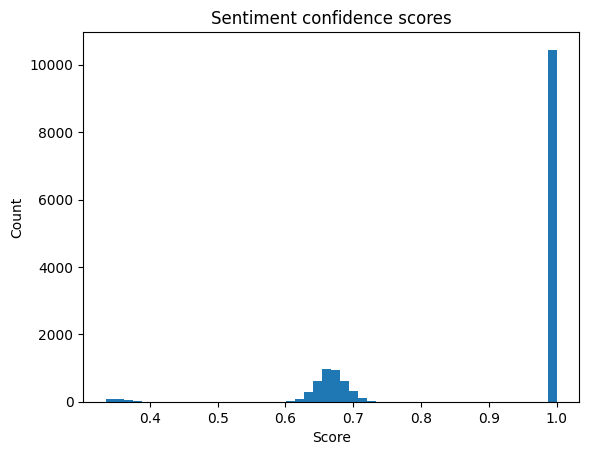

In [27]:
# Plot a histogram of confidence scores

import matplotlib.pyplot as plt

plt.hist(df['airline_sentiment_confidence'], bins=50)
plt.title("Sentiment confidence scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [28]:
# Filter out low confidence labels

def remove_low_conf(text,label,score):
    return tf.math.greater(score,0.5)

train_dataset = train_dataset.filter(remove_low_conf)
val_dataset = val_dataset.filter(remove_low_conf)
test_dataset = test_dataset.filter(remove_low_conf)

In [29]:
# Create inputs and outputs

def text_label(text,label,score):
    return text,label

train_dataset = train_dataset.map(text_label)
val_dataset = val_dataset.map(text_label)
test_dataset = test_dataset.map(text_label)

In [30]:
# Shuffle the training Dataset

train_dataset = train_dataset.shuffle(500)

In [31]:
# View a sample from the training Dataset

for elem in train_dataset.take(1):
    print(elem)

(<tf.Tensor: shape=(), dtype=string, numpy=b'@JetBlue When it\'s 30 mins past scheduled time w/ no departure in sight a flight no longer qualifies as "on time" #updateyourwebsite #489'>, <tf.Tensor: shape=(), dtype=string, numpy=b'negative'>)


In [32]:
# Batch the Datasets

train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)

#### Preprocessing layers
We will need to convert the string data into a numeric representation for the models to process it. We will do this using [preprocessing layers](https://keras.io/guides/preprocessing_layers/). 

First we will look at the output labels, and convert them to a one-hot encoding using the `StringLookup` and `CategoryEncoding` layers.

In [33]:
# Create a StringLookup layer

from keras.layers import StringLookup
#converts string lookups to integer values

output_labels = ["positive", "negative", "neutral"]
#by default, out of vocab text labels are set to 0, so then the above would be (1,2,3), but we dont need this
stringlookup = StringLookup(vocabulary = output_labels,num_oov_indices=0)
#now will be mapped to (0,1,2)

In [34]:
# View the output of the StringLookup layer

for t,l in train_dataset.take(1):
    print(l)
    print(stringlookup(l))

tf.Tensor(
[b'negative' b'negative' b'positive' b'neutral' b'positive' b'negative'
 b'neutral' b'neutral' b'positive' b'negative' b'negative' b'neutral'
 b'negative' b'positive' b'negative' b'negative'], shape=(16,), dtype=string)
tf.Tensor([1 1 0 2 0 1 2 2 0 1 1 2 1 0 1 1], shape=(16,), dtype=int64)


In [35]:
# Apply the label preprocessing to the Datasets

def convert_to_integer(text,labels):
    return text, stringlookup(labels)

train_dataset = train_dataset.map(convert_to_integer)
val_dataset = val_dataset.map(convert_to_integer)
test_dataset = test_dataset.map(convert_to_integer)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Now we will process the input tweet text - this can be handled using the `TextVectorization` layer.

In [36]:
# Create a TextVectorization layer

#can put all of the preprocessing stuff into the model via a layer

from keras.layers import TextVectorization
textvectorisation = TextVectorization(max_tokens=1000)
#could be any number of unique strings
#but there are often those used rarely, so dont carry enough info for model, often better not using
#so we set the size as 1000
#we set max tokens as 1000, 0 is reserved for masking, and 1 is out of vocab tokens 
#so once the 998 token values are used, rest are set to 1

#this layer gets rid of whitespace, lowercases and gets rid of punctutation

In [37]:
# Configure the layer to the dataset

#next we setup the tokens by adapting
textvectorisation.adapt(train_dataset.map(lambda t, l: t))
#there is a method where you can set the vocab yourself if you know it

In [38]:
for t, l in train_dataset.take(1):
    print(t)
    print(textvectorisation(t))

#padded with 0s until longest tweet so they can be in a tensor
#1s will be unusual words

tf.Tensor(
[b"@USAirways The airline is embarrassing itself. I get that bad weather isn't your fault, but your response to it couldn't have been worse."
 b"@AmericanAir for my delay and you know what I get a we don't credit anybody back a supervisor who cut me off when speaking"
 b'@united I have and been denied! I called and got hung up on. Did speaks with manager on second call'
 b"@SouthwestAir I'm smashed into a window by the giant guest sitting next to me. #4386. No way this guy should have been given 1 seat."
 b'@united - blamed weather lol 78 no wind and not a cloud in the sky!! Delayed both ways 4x!! RU kidding me to charge me for 1.5lb w/8 delays?'
 b"@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st.  Thanks guys!"
 b"@AmericanAir I don't like making a scene but this hasn't been addressed properly. Please have them do that."
 b"@JetBlue what's up? Three delays so far, resulting in over three hours of unnecessary, extra waiting."
 b'Well lets see. 

#### Embedding layer
We are now able to process the text data into numerical form. However, the input integer tokens should be further processed to transform them into a representation that is more useful for the network. This is where the `Embedding` layer can be used - it creates a lookup table of vectors in $\mathbb{R}^D$ such that each integer token in the vocabulary has its own $D$-dimensional embedding vector.

In [48]:
# Create an Embedding layer

from keras.layers import Embedding

#1000 vocab size, including the masking token and OOV token
#and dimension of embedding space 2 since it is not very complex 
#each row is embedding for each integer token
#given sequence it returns sequence of embeddings

### MASKING ###
#we padded with 0s to make the tensors the same size
#hence 0 has no meaning, so tell the model that. Any zeros should be ignored
#this info is passed onto subsequent layers and loss function
embedding = Embedding(1000,2,mask_zero=True)


In [49]:
# View the output of the Embedding layer

for t, l in train_dataset.take(1):
    #print(embedding(textvectorisation(t)).shape)
    print(embedding(textvectorisation(t))._keras_mask)
    #False are zero tokens added by the text vectorisation layer
    #keras mask property is passed to layers that follow

tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True False False False False False False False False False
  False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True False False False False False False False False False False
  False False]
 [ True  True  True  True  True  True  True  True False False False False
  False False False False False False False False False False False False
  False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True False False
  False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True False
  False False]
 [ True  Tr

In [50]:
# Build the classifier model
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense


In [51]:
# Compile and train the model

lstm_classifier = Sequential([
    textvectorisation,
    embedding,
    #take future and past directions
    Bidirectional(LSTM(8)),
    #3 way softmax, one for each class
    Dense(3, activation = "softmax")
])

In [52]:
# Evaluate the model on the test Dataset

lstm_classifier.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = lstm_classifier.fit(train_dataset, validation_data=val_dataset, epochs = 5)

Epoch 1/5
540/540 [==============================] - 16s 17ms/step - loss: 0.7787 - accuracy: 0.6675 - val_loss: 0.6393 - val_accuracy: 0.7068
Epoch 2/5
540/540 [==============================] - 8s 14ms/step - loss: 0.6110 - accuracy: 0.7399 - val_loss: 0.5998 - val_accuracy: 0.7279
Epoch 3/5
540/540 [==============================] - 7s 13ms/step - loss: 0.5600 - accuracy: 0.7656 - val_loss: 0.5796 - val_accuracy: 0.7560
Epoch 4/5
540/540 [==============================] - 7s 12ms/step - loss: 0.5329 - accuracy: 0.7824 - val_loss: 0.5738 - val_accuracy: 0.7574
Epoch 5/5
540/540 [==============================] - 8s 14ms/step - loss: 0.5165 - accuracy: 0.7934 - val_loss: 0.5721 - val_accuracy: 0.7660


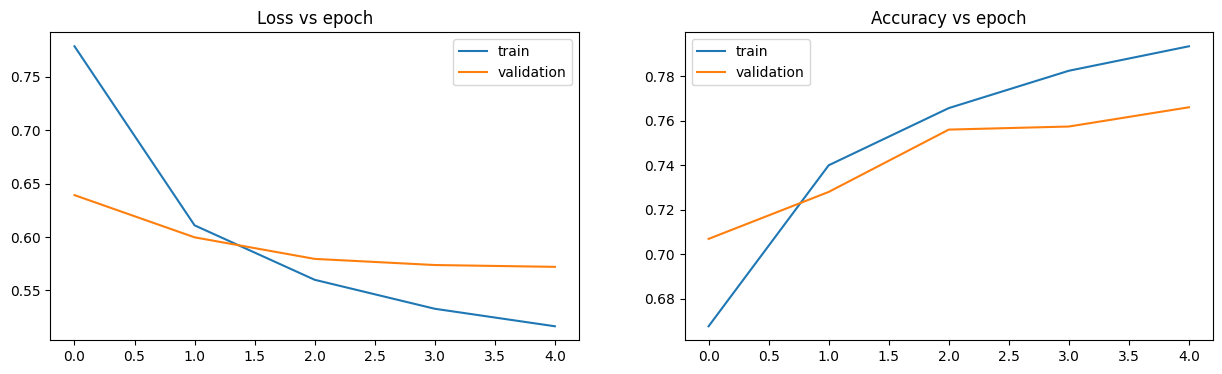

In [53]:
# Plot the learning curves

fig = plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss vs epoch")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy vs epoch")

plt.show()

In [54]:
# View some model predictions on the test set

import numpy as np

for text, label in test_dataset.take(1):
    ground_truth = np.array(output_labels)[label]
    predicted_label_ints = np.argmax(lstm_classifier(text).numpy(), axis=1)
    predicted_labels = np.array(output_labels)[predicted_label_ints]

for t, l, g in zip(text, predicted_labels, ground_truth):
    print(t.numpy().decode('utf-8'))
    print("True label: {}\nPredicted label: {}\n".format(g, l))

@AmericanAir great customer service thanks
True label: positive
Predicted label: positive

@SouthwestAir not to mention I now have to sit in the airport for 4 hours. You've ruined my trip. I am not happy and want compensation.
True label: negative
Predicted label: negative

@united I see several economy plus can you put us in those. We don't have to be seated together
True label: neutral
Predicted label: neutral

@JetBlue I'm sick of y'all.
True label: negative
Predicted label: neutral

@AmericanAir Thanks, but that results in missing the conference I'm attending. Are there options to book earlier,or if not,receive a refund?
True label: negative
Predicted label: negative

@USAirways how can i get ahold of a reservations supervisor?
True label: neutral
Predicted label: negative

@JetBlue great flight and crew! Flight 51 from BOS to MCO
True label: positive
Predicted label: positive

@united whom can I call to discuss - as I was told that united has no phone contact with passengers  - th

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Cho14"></a>
* Cho, K., van Merriënboer, B., Gülçehre, Ç., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014), "Learning phrase representations using rnn encoder–decoder for statistical machine translation", in *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)*, 1724–1734.
<a class="anchor" id="Gers99"></a>
* Gers, F.A. (1999), "Learning to forget: Continual prediction with LSTM", *9th International Conference on Artificial Neural Networks: ICANN '99*, 850–855.
<a class="anchor" id="Graves09"></a>
* Graves, A., Liwicki, M., Fernández, S., Bertolami, R., Bunke, H., & Schmidhuber, J. (2009), "A Novel Connectionist System for Unconstrained Handwriting Recognition", *IEEE Transactions on Pattern Analysis and Machine Intelligence*, **31** (5), 855–868.
<a class="anchor" id="Graves13"></a>
* Graves, A., Mohamed, A.-R., Hinton, G. (2013), "Speech Recognition with Deep Recurrent Neural Networks", arXiv preprint, abs/1303.5778.
<a class="anchor" id="Hochreiter91"></a>
* Hochreiter, S. (1991), "Untersuchungen zu dynamischen neuronalen Netzen", Diploma thesis, Institut für Informatik, Lehrstuhl Prof. Brauer, Technische Universität München.
<a class="anchor" id="Hochreiter97"></a>
* Hochreiter, S. and Schmidhuber, J. (1997), "Long short-term memory", *Neural Computation*, **9** (8), 1735–1780.
<a class="anchor" id="Rumelhart86b"></a>
* Rumelhart, D. E., Hinton, G., and Williams, R. (1986b), "Learning representations by back-propagating errors", Nature, **323**, 533-536.
<a class="anchor" id="Schuster97"></a>
* Schuster, M. & Paliwal, K. K. (1997), "Bidirectional Recurrent Neural Networks", *IEEE Transactions on Signal Processing*, **45** (11), 2673-2681.
<a class="anchor" id="Vinyals19"></a>
* Vinyals, O., Babuschkin, I., Czarnecki, W. M., Mathieu, M., Dudzik, A., Chung, J., Choi, D. H., Powell, R., Ewalds, T., Georgiev, P., Oh, J., Horgan, D., Kroiss, M., Danihelka, I., Huang, A., Sifre, L., Cai, T., Agapiou, J. P., Jaderberg, M., Vezhnevets, A. S., Leblond, R., Pohlen, T., Dalibard, V., Budden, D., Sulsky, Y., Molloy, J., Paine, T. L., Gulcehre, C., Wang, Z., Pfaff, T., Wu, Y., Ring, R., Yogatama, D., Wünsch, D., McKinney, K., Smith, O., Schaul, T., Lillicrap, T., Kavukcuoglu, K., Hassabis, D., Apps, C., & Silver, D.(2019) "Grandmaster level in StarCraft II using multi-agent reinforcement learning", *Nature*, **575** (7782), 350-354.
<a class="anchor" id="Wu16"></a>
* Wu, Y., Schuster, M., Chen, Z., Le, Q. V., Norouzi, M, Macherey, W., Krikun, M., Cao, Y., & Gao, Q. (2016), "Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation", arXiv preprint, abs/1609.08144.